In [ ]:
%run FUNCIONES_GENERALES.ipynb

In [2]:
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt

# skforecast
import skforecast
import pandas as pd
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from pmdarima import auto_arima 

import warnings
warnings.filterwarnings('once')

/home/khaosdev/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/khaosdev/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [51]:
def prediccion_autorregresivos(datos,datos_train,fin_val):
    
    # Grid search
    forecaster = ForecasterSarimax(
                    regressor=Sarimax(
                                    order=(1, 1, 1), # Placeholder replaced in the grid search
                                    maxiter=500
                                )
                )

    param_grid = {
        'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
        'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
        'trend': [None]
    }

    resultados_grid = grid_search_sarimax(
                            forecaster            = forecaster,
                            y                     = datos['Precio'],
                            param_grid            = param_grid,
                            steps                 = 12,
                            refit                 = True,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = len(datos_train),
                            fixed_train_size      = False,
                            return_best           = False,
                            n_jobs                = 'auto',
                            suppress_warnings_fit = True,
                            verbose               = False,
                            show_progress         = True
                    )
    r=resultados_grid.index[0]
    
    # Auto arima: seleccion basada en AIC
    # ==============================================================================
    modelo = auto_arima(
                y                 = datos['Precio'],
                start_p           = 0,
                start_q           = 0,
                max_p             = 3,
                max_q             = 3,
                seasonal          = True,
                test              = 'adf',
                m                 = 12, # periodicidad de la estacionalidad
                d                 = None, # El algoritmo determina 'd'
                D                 = None, # El algoritmo determina 'D'
                trace             = True,
                error_action      = 'ignore',
                suppress_warnings = True,
                stepwise          = True
            )
    # Predicciones de backtesting con el mejor modelo según el grid search
    # ==============================================================================
    forecaster_1 = ForecasterSarimax( regressor=Sarimax(order=resultados_grid.order[r], seasonal_order=resultados_grid.seasonal_order[r], maxiter=500),
                    )

    metrica_m1, predicciones_m1 = backtesting_sarimax(
                                            forecaster            = forecaster_1,
                                            y                     = datos['Precio'],
                                            initial_train_size    = len(datos.loc[:fin_val]),
                                            steps                 = 24,
                                            metric                = 'mean_absolute_error',
                                            refit                 = True,
                                            n_jobs                = "auto",
                                            suppress_warnings_fit = True,
                                            verbose               = False,
                                            show_progress         = True
                                        )

    # Predicciones de backtesting con el mejor modelo según auto arima
    # ==============================================================================
    forecaster_2 = ForecasterSarimax(
                        regressor=Sarimax(order=modelo.order, seasonal_order=modelo.seasonal_order, maxiter=500),
                    )

    metrica_m2, predicciones_m2 = backtesting_sarimax(
                                            forecaster            = forecaster_2,
                                            y                     = datos['Precio'],
                                            initial_train_size    = len(datos.loc[:fin_val]),
                                            steps                 = 24,
                                            metric                = 'mean_absolute_error',
                                            refit                 = True,
                                            n_jobs                = "auto",
                                            suppress_warnings_fit = True,
                                            verbose               = False,
                                            show_progress         = True
                                        )
    
    # Comparación de métricas
    # ==============================================================================
    print("Metrica (mean absolute error) del modelo grid search:")
    display(metrica_m1)
    print("Metric (mean_absolute_error) del modelo auto arima:")
    display(metrica_m2)

    fig, ax = plt.subplots(figsize=(6, 3))
    datos.loc[fin_val:].plot(ax=ax, label='test')
    predicciones_m1 = predicciones_m1.rename(columns={'pred': 'grid search'})
    predicciones_m2 = predicciones_m2.rename(columns={'pred': 'autoarima'})
    predicciones_m1.plot(ax=ax)
    predicciones_m2.plot(ax=ax)
    ax.set_title('Predicciones de backtesting con un modelo SARIMA')
    ax.legend()
    
 

In [4]:
# Parámetros de los modelos:
paramsD1=[1,[350,23]]
paramsD2=[2,[20,0.6,200]]
params_ARMA1 = [250,0.6,3, [0.12,0.24],[0.3],[]]
params_ARMA2 = [270,1.5,0, [0.8],[0.3,0.25],[]]
params_per1= [1,1,[200,10],12]
params_per2= [2,1,[250,13],3]
params_tend1 = [[200,0.3],1,0.3]
params_tend2 = [[150,-4,0.2],2,0.15]

In [5]:
fecha1='1/1/2012'

In [6]:
fecha2='1/1/2024'

In [8]:
fecha3='1/1/2026'

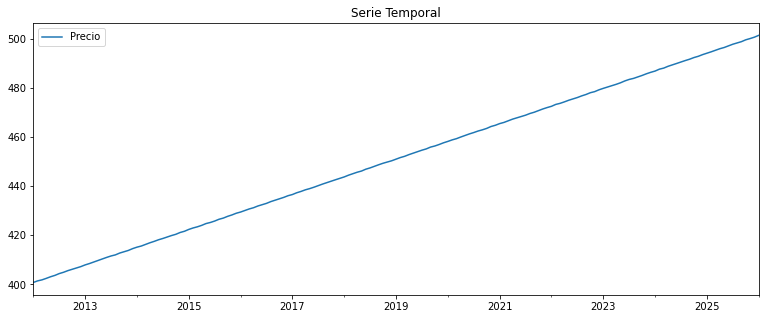

In [10]:
df1 = crear_df_fin_tend_det(fecha1,fecha3,'MS',['Precio'],[400,0.6],1,0.2)

In [13]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df1_train = df1.loc[:fin_train]
df1_test  = df1.loc[fin_train:]

Number of models compared: 15.


params grid:   0%|          | 0/15 [00:00<?, ?it/s]

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1350.207, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2181.676, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=150.482, Time=0.15 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-141.407, Time=0.47 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-145.903, Time=1.47 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-138.302, Time=1.76 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-145.184, Time=0.46 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=inf, Time=0.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


,mean_absolute_error
0,0.043438


Metric (mean_absolute_error) del modelo auto arima:


,mean_absolute_error
0,0.165922


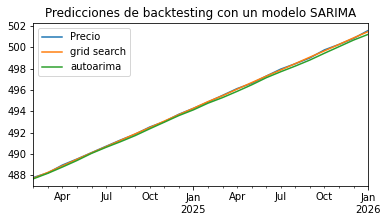

In [24]:
prediccion_autorregresivos(df1,df1_train,fin_train)

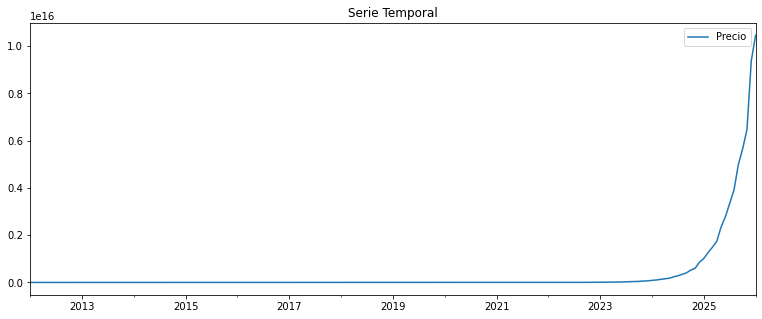

In [26]:
df2 = crear_df_fin_tend_det(fecha1,fecha3,'MS',['Precio'],[3,0.2],3,0.2)

In [27]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df2_train = df2.loc[:fin_train]
df2_test  = df2.loc[fin_train:]

Number of models compared: 15.


params grid:   0%|          | 0/15 [00:00<?, ?it/s]

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=8502.598, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=8493.245, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=8458.362, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=8456.428, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=8458.362, Time=0.06 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=8460.362, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=8354.688, Time=0.09 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=8355.737, Time=0.27 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=8355.742, Time=0.24 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=8357.716, Time=0.32 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=inf, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=8.000, Time=0.19 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=8326.925, Time=0.23 sec
 ARIMA(2,2,1)(0,0,1)[12]        

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


,mean_absolute_error
0,2.444340e+15


Metric (mean_absolute_error) del modelo auto arima:


,mean_absolute_error
0,2.444340e+15


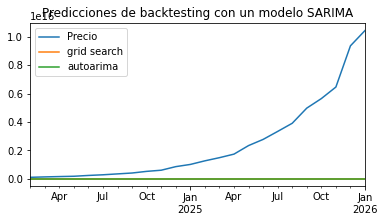

In [29]:
prediccion_autorregresivos(df2,df2_train,fin_train)

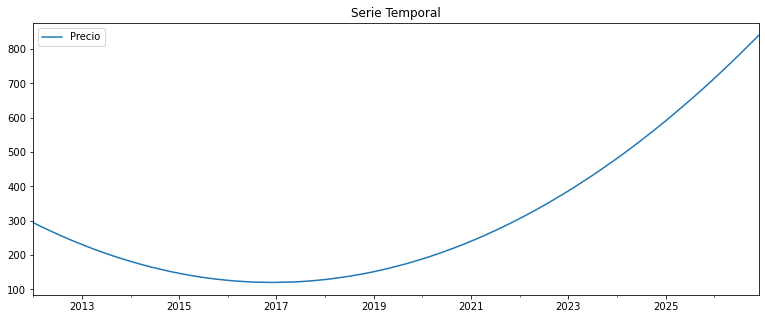

In [32]:
df3 = crear_df_periodos_tend_det(fecha1,180,'MS',['Precio'],[300,-6,0.05],2,0.2)

In [33]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df3_train = df3.loc[:fin_train]
df3_test  = df3.loc[fin_train:]

Number of models compared: 15.


params grid:   0%|          | 0/15 [00:00<?, ?it/s]

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=822.964, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=834.398, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=641.530, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=333.096, Time=0.17 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=59.074, Time=1.20 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=-7.504, Time=1.58 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=282.652, Time=0.39 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.38 sec
 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


,mean_absolute_error
0,0.073787


Metric (mean_absolute_error) del modelo auto arima:


,mean_absolute_error
0,0.232893


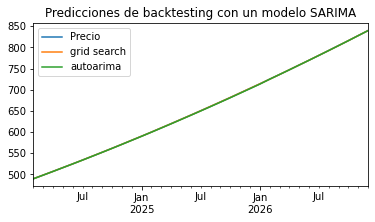

In [46]:
prediccion_autorregresivos(df3,df3_train,fin_train)

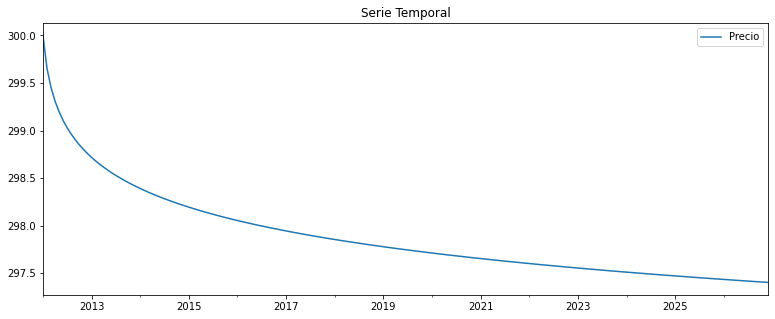

In [38]:
df4 = crear_df_periodos_tend_det(fecha1,180,'MS',['Precio'],[300,-0.5],4,0.2)

In [39]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df4_train = df4.loc[:fin_train]
df4_test  = df4.loc[fin_train:]

prediccion_autorregresivos(df4,df4_train,fin_train)

In [40]:
prediccion_autorregresivos(df4,df4_train,fin_train)

Number of models compared: 15.


params grid:   0%|          | 0/15 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

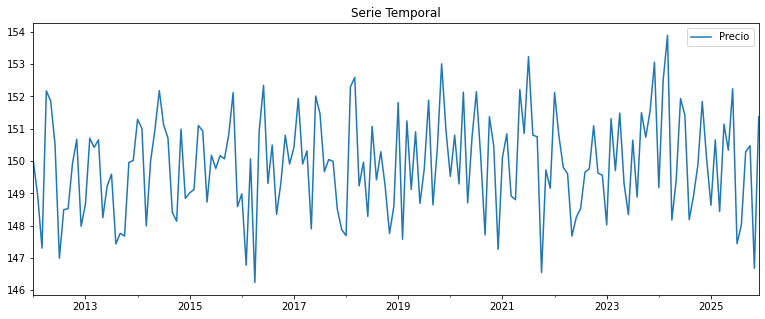

In [41]:
df5=crear_df_fin_datos(fecha1,fecha3,'M',['Precio'],1,[150,1.5])

Number of models compared: 15.


params grid:   0%|          | 0/15 [00:00<?, ?it/s]

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=525.278, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=527.478, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=526.340, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1853.504, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=527.278, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=525.131, Time=0.05 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=526.906, Time=0.19 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=528.906, Time=0.87 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=526.395, Time=0.18 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=528.327, Time=0.20 sec
 ARIMA(0,0,0)(0,0,1)[12]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,1)[12] intercept
Total fit time: 2.426 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


,mean_absolute_error
0,1.442868


Metric (mean_absolute_error) del modelo auto arima:


,mean_absolute_error
0,114.839771


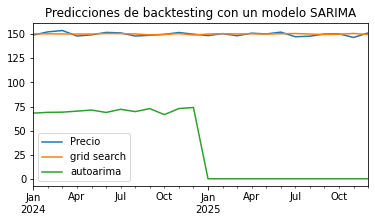

In [42]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df5_train = df5.loc[:fin_train]
df5_test  = df5.loc[fin_train:]

prediccion_autorregresivos(df5,df5_train,fin_train)

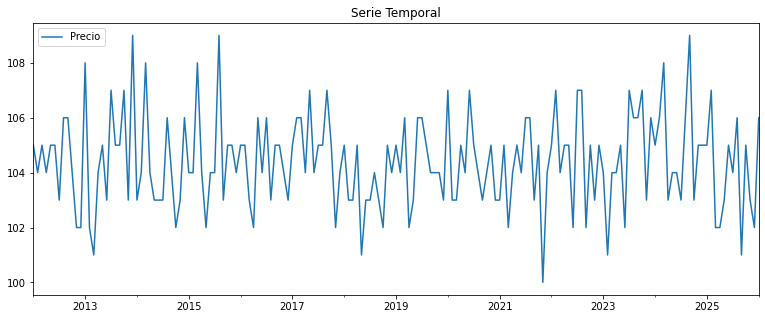

In [44]:
df6=crear_df_fin_datos(fecha1,fecha3,'MS',['Precio'],2,[15,0.3,100])

Number of models compared: 15.


params grid:   0%|          | 0/15 [00:00<?, ?it/s]

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=565.298, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=561.307, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=563.753, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=563.503, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1761.477, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=563.307, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=563.298, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=561.757, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=561.513, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=563.719, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.857 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


,mean_absolute_error
0,1.530118


Metric (mean_absolute_error) del modelo auto arima:


,mean_absolute_error
0,104.458333


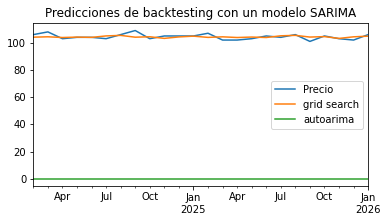

In [45]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df6_train = df6.loc[:fin_train]
df6_test  = df6.loc[fin_train:]

prediccion_autorregresivos(df6,df6_train,fin_train)

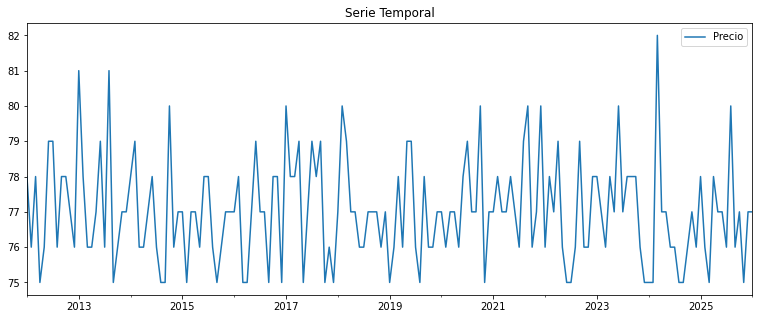

In [48]:
df7=crear_df_fin_datos(fecha1,fecha3,'MS',['Precio'],3,[2,75])

Number of models compared: 15.


params grid:   0%|          | 0/15 [00:00<?, ?it/s]

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=614.031, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=611.355, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=667.371, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=613.837, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1949.972, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=612.047, Time=0.39 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=612.021, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=613.167, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=613.106, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=615.340, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.710 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


,mean_absolute_error
0,1.175574


Metric (mean_absolute_error) del modelo auto arima:


,mean_absolute_error
0,76.708333


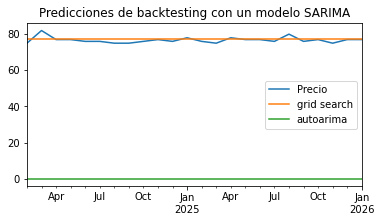

In [52]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df7_train = df7.loc[:fin_train]
df7_test  = df7.loc[fin_train:]

prediccion_autorregresivos(df7,df7_train,fin_train)

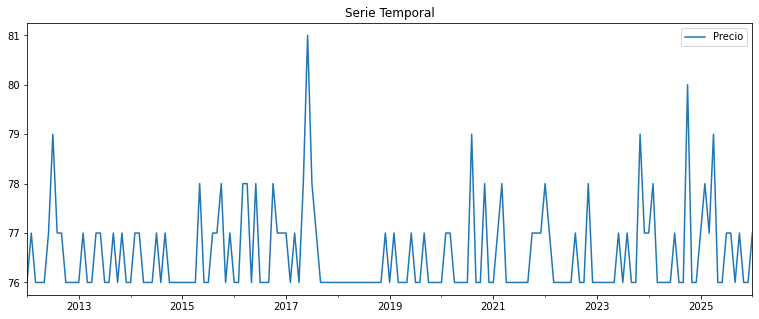

In [54]:
dfg=crear_df_fin_datos(fecha1,fecha3,'MS',['Precio'],4,[0.62,75])

Number of models compared: 15.


params grid:   0%|          | 0/15 [00:00<?, ?it/s]

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=433.742, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=435.441, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=435.009, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1947.849, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=435.742, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=435.493, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=433.619, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=435.243, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=435.417, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=435.660, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=433.430, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=435.430, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : A

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


,mean_absolute_error
0,0.790019


Metric (mean_absolute_error) del modelo auto arima:


,mean_absolute_error
0,75.181133


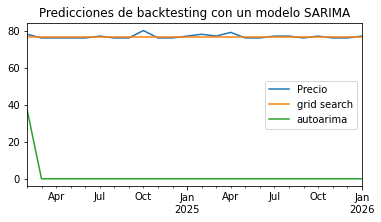

In [55]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
dfg_train = dfg.loc[:fin_train]
dfg_test  = dfg.loc[fin_train:]

prediccion_autorregresivos(dfg,dfg_train,fin_train)